In [523]:
# Packages nécessaires
%pylab inline
import itertools
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Compte-rendu du TP4 d'Apprentissage Statistique (ENSAE ParisTech)

**1. Choisissez un jeux de données sur le web (le site https://archive.ics.uci.edu/
ml/datasets.html, par exemple, en contient un certain nombre).**

Le jeu de données que nous avons choisi est le suivant :

### https://archive.ics.uci.edu/ml/datasets/Wilt

Ce jeu de données a été étudié dans l'article suivant :

Johnson, B., Tateishi, R., Hoan, N., 2013. A hybrid pansharpening approach and multiscale object-based image analysis for mapping diseased pine and oak trees. International Journal of Remote Sensing, 34 (20), 6969-6982.

Ce dataset est constitué d'une base d'apprentissage de 4339 individus, et d'une base de test de 500 individus. Nous utiliserons ces deux dataset pour cette tâche de classification, la base de train sera réservée à l'apprentissage tandis que la base de test sera utilisée pour l'évaluation des modèles.

Les variables sont les suivantes : 

- classe : 'w' (diseased trees), 'n' (all other land cover) 
- GLCM_Pan: GLCM mean texture (Pan band)  
- Mean_G: Mean green value 
- Mean_R: Mean red value 
- Mean_NIR: Mean NIR value 
- SD_Pan: Standard deviation (Pan band) 

Elles représentent des caractéristiques d'images associées à la détéction de maladie chez les chênes.

Le jeu de données est déséquilibré, en effet 98% des individus sont labelés sains, et seulement 2% des invidivus sont labelés malades. Le but est justement de savoir détecter lorsqu'un individu est malade. Ainsi, la base de test est **ré-équilibrée** avec 37% des invidividus classés comme malades, et 63% des individus classés comme sains.

Il faudra faire donc attention lors de l'apprentissage à ce déséquilibre dans la base d'apprentissage. Par exemple, le choix de la loss function sera crucial dans certains algorithmes.

**2. Effectuez de la classification et/ou de la régression pour les données choisies en
utilisant les méthodes vues en cours/TD.**

**3. Rédigez un compte-rendu qui résume le problème étudié, la modélisation utilisée,
les méthodes employées et les résultats obtenus.**

**4. Discutez de la pertinence des résultats obtenus.**

On commence par charger les données en mémoire (base de train et de test) et on les mets en forme pour appliquer les algorithmes de classification. Il faut notamment changer la colonne des classes de ('n','w') vers (0,1). On peut vérifier le déséquilibre des proportions de malades/sains.

In [492]:
#Load the data
data= pd.read_csv('training.csv', sep=",", names=['class','1','2','3','4','5'])
X_train=data[['1','2','3','4','5']].as_matrix()
y_train=data['class'].as_matrix()
data= pd.read_csv('testing.csv', sep=",", names=['class','1','2','3','4','5'])
X_test=data[['1','2','3','4','5']].as_matrix()
y_test=data['class'].as_matrix()


#Reshape the data
for i in range(len(X_train)):
    if y_train[i]=='w':
        y_train[i]=1
    else:
        y_train[i]=0
        
for i in range(len(X_test)):
    if y_test[i]=='w':
        y_test[i]=1
    else:
        y_test[i]=0

y_train=y_train.astype(int)
y_test=y_test.astype(int)

#Verify that classes are imbalanced
print(sum(y_train==0)/len(y_train), '% d\'individus sains : la base de train est fortement déséquilibrée.')
print(sum(y_test==0)/len(y_test),'% d\'individus sains : la base de test est ré-équilibrée.')

0.98294537912 % d'individus sains : la base de train est fortement déséquilibrée.
0.626 % d'individus sains : la base de test est ré-équilibrée.


Les variables ne sont pas centrées ni réduites, et cela peut poser un problème lors de l'apprentissage concernant plusieurs alogorithmes, par exemple SVM. Pour remédier à ce problème, on peut calculer la moyenne et l'écart-type de chaque variable, puis centrer et réduire les deux bases. On calcule ces quantités sur la base de train, et on applique la même transformation à la base de test. Si on calcule ces quantités sur la base de test, comme celle-ci est ré-équilibrée, les résultats seront faussés.

In [493]:
#Preprocessing : get to mean 0 and variance 1
M=X_train.mean(axis=0)
std=X_train.std(axis=0)
X_train = (X_train-M)/std
X_test = (X_test-M)/std

Nous allons comparer 5 algorithmes classiques : **kNN, SVM, random Forest, fully-connected neural network et gradient boosting**. Ces modèles diffèrent par leur type, nombre d'hyperparamètres, temps d'apprentissage, date de découverte... Ils offrent une bonne représentation des algorithmes d'apprentissage supervisé les plus utilisés. Pour chaque algorithme, le procédé suivant sera appliqué :

- Premièrement, l'algorithme sera rapidement présenté, puis nous la méthode fit sera appliquée à la base de train. 

- Ensuite une prédiction sera obtenu sur la base de test grâce à la méthode prédict, et nous conserverons aussi les prédictions des probabilités d'appartenance aux deux classes pour les courbes ROC. 

- Enfin, nous afficherons le score de précision (% d'individus bien classés) et la matrice de confusion.

### kNN

Cet algorithme, très intuitif et peu récent, n'est souvent pas celui qui offre les meilleurs résultats. Cependant, il permet de mieux comprendre le dataset car ses résultats s'interprètent facilement : la prédiction d'un nouvel individu est simplement le résultat du vote parmi les k-plus proches voisins de l'individu en question. 

L'implémentation utilisée est celle de Scikit-Learn.

In [494]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
_y=knn.predict(X_test)
score=accuracy_score(y_test,_y)
print(score)
print(confusion_matrix(y_test, _y))

0.674
[[310   3]
 [160  27]]


In [495]:
p_knn=knn.predict_proba(X_test)

### SVM

L'agorithme Support Vector Machine résoud un problème d'optimisation qui cherche à trouver le meilleur hyperplan dans un espace judicieusement choisi. Cet algorthme est plus récent (années 2000), et est très bien fondé mathématiquement. Les hyper-paramètres que l'on a optimisé sont le kernel (choix de l'espace) et les coefficients $C$ et $\gamma$.

L'implémentation utilisée est celle de Scikit-Learn.

In [519]:
svm = SVC(C=2, class_weight='balanced', kernel='rbf', probability=True, gamma=1)
svm.fit(X_train, y_train)
_y=svm.predict(X_test)
score=accuracy_score(y_test,_y)
print(score)
cm_svm=confusion_matrix(y_test, _y) #useful later on
print(confusion_matrix(y_test, _y))

0.852
[[278  35]
 [ 39 148]]


In [497]:
p_svm=svm.predict_proba(X_test)

### Random forest

L'algorithme Random forest effectue un apprentissage sur de multiples arbres de décision entraînés sur des sous-ensembles de données légèrement différents, en utilisant des techniques statistiques. Développé et fondé mathématiquement au début des années 2000, cet algorithme est fortement utilisé car il est très pratique. Notamment, il peut comprendre les variable catégorielles.

L'implémentation utilisée est celle de Scikit-Learn.

In [510]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train,y_train)
_y=rf.predict(X_test)
score=accuracy_score(y_test,_y)
print(score)
print(confusion_matrix(y_test, _y))

0.776
[[312   1]
 [111  76]]


In [511]:
p_rf=rf.predict_proba(X_test)

### Fully-connected neural network

Le Deep Learning reçoit une attention très importante depuis 2012, et même si son fondement mathématique n'est pas résolu, cette classe d'algorithmes a obtenu les meilleurs résultats dans beaucoup de domaines comme la vision ou la reconnaissance de la parole. Crées en 1998, ils ne sont utilisés que depuis récemment car ils nécéssitent une puissance de calcul élevée et des tailles de base de données importantes. Cependant, les réseaux de neurones sont aussi viables pour des problèmes classiques d'apprentissage supervisé.

Nous avons utilisé Keras avec TensorFlow pour créer un réseau à 2 couches cachées qui sont fully-connected. La sortie de l'algorithme est la probabilité que l'individu soit sain. La loss function utilisée est la logloss (ou cross-entropy). Soit $y_i$ une variable qui vaut 1 si l'individu i est bien classé et 0 sinon, et soit $\widehat{p}_i$ la probabilité estimée d'appartenance à la classe 1 $\widehat{p}_i=\widehat{\mathbb{P}(Y_i=1|X)}$, la logloss est :

$$ Logloss (\widehat{y},y)=-\frac{1}{n}\sum_{i=1}^{n}y_i*\log(\widehat{p}_i)+(1-y_i)*\log(1-\widehat{p}_i)$$

Cette loss est adaptée au problèmes où les proportions des labels sont inégales. 

Les fonctions d'activations sont RELU pour les deus couches cachées, et sigmoid (pour obtenir la probabilité) pour la sortie. L'optimiseur utilisé est Adam.

In [542]:
# create model
nn = Sequential()
nn.add(Dense(12, input_dim=5, init='uniform', activation='relu'))
nn.add(Dense(8, init='uniform', activation='relu'))
nn.add(Dense(1, init='uniform', activation='sigmoid'))

In [543]:
# Compile model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
nn.fit(X_train, y_train, nb_epoch=400, batch_size=10, verbose=0)
# evaluate the model
scores = nn.evaluate(X_test, y_test)

 32/500 [>.............................] - ETA: 3s

In [553]:
print(scores)
p_nn=nn.predict_proba(X_test)
_y=np.round(p_nn)
print('\n')
cm_nn=confusion_matrix(y_test, _y) #useful later on
print(confusion_matrix(y_test, _y))

[0.70585651302337649, 0.87399999952316287]
 32/500 [>.............................] - ETA: 0s

[[300  13]
 [ 50 137]]


In [554]:
a=[]
for i in range(len(p_nn)):
    a.append(np.append(p_nn[i],1-p_nn[i]).astype('float'))
p_nn=a
p_nn=np.asarray(p_nn)

### Gradient boosting

Le gradient boosting, crée dans les années 2000 et bien fondé mathématiquement, est très populaire dans les compétitions Kaggle, et offre souvent les meilleurs résultats pour les problèmes d'apprentissage supervisé. Cet algorithme est constitué d'un ensemble de prédicteurs faibles, ici des arbres de décision. Le but est d'optimiser selon une loss function en ajoutant des classifieurs ou fur et à mesure, tout en utilisant une régularisation dans l'optimisation.

L'implémentation utilisée est celle de XGBoost.

In [550]:
boost = xgb.XGBClassifier(gamma=0.1,base_score=0.1,learning_rate=0.8)
boost.fit(X_train, y_train)
_y=boost.predict(X_test)
p_boost=boost.predict_proba(X_test)
score=accuracy_score(y_test,_y)
print(score)
print(confusion_matrix(y_test, _y))

0.822
[[306   7]
 [ 82 105]]


### Récapitulatif des résultats après calibration des hyper-paramètres

Dans la tableau suivant nous récapitulons les résultats obtenus, en terme de simple précision : 

| Algorithm | Accuracy on test set
| :-: |:-:
| kNN | 67.4% 
| SVM | 85.2% 
| Random forest | 77.6% 
| Fully-connected Neural net |  87.4% 
| Gradient boosting | 82.2% 

Le réseau de neurones semble obtenir les meilleurs résultats. SVM et Gradient boosting ont des résultats très satisfaisants aussi, Random forest un peu moins et kNN ne donne pas grand chose.




### Courbes ROC

Pour mieux apprécier les résultats des algorithmes, nous allons utiliser leurs courbes ROC, et l'aire sous la courbe ROC. Ces deux nouvelles métriques permettent de mieux apprécier la qualité des classifieurs obtenus.

In [555]:
#kNN 
fpr_knn, tpr_knn, _ = roc_curve(y_test, p_knn[:,1])
auc_knn=roc_auc_score(y_test, p_knn[:,1])

#SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, p_svm[:,1])
auc_svm=roc_auc_score(y_test, p_svm[:,1])

#Random forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, p_rf[:,1])
auc_rf=roc_auc_score(y_test, p_rf[:,1])

#Neural net 
fpr_nn, tpr_nn, _ = roc_curve(y_test, p_nn[:,0])
auc_nn=roc_auc_score(y_test, p_nn[:,0])

#XGBoost
fpr_boost, tpr_boost, _ = roc_curve(y_test, p_boost[:,1])
auc_boost=roc_auc_score(y_test, p_boost[:,1])

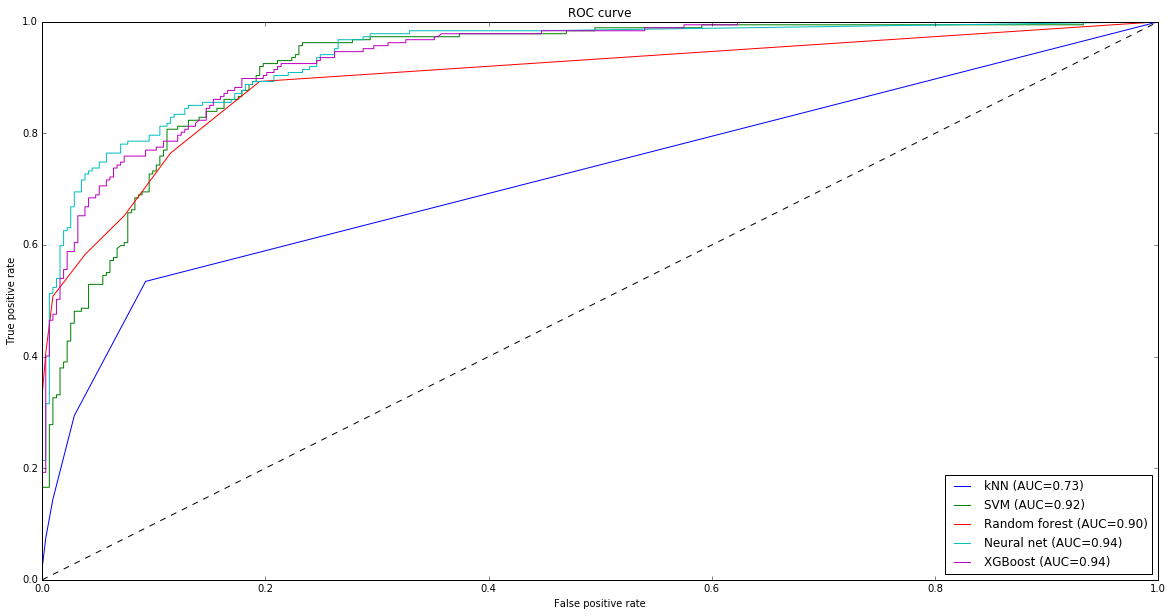

In [556]:
plt.figure(1,figsize=(20,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label='kNN (AUC=%.2f)' %auc_knn)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC=%.2f)' %auc_svm)
plt.plot(fpr_rf, tpr_rf, label='Random forest (AUC=%.2f)' %auc_rf)
plt.plot(fpr_nn, tpr_nn, label='Neural net (AUC=%.2f)' %auc_nn)
plt.plot(fpr_boost, tpr_boost, label='XGBoost (AUC=%.2f)' %auc_boost)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

On peut voir que kNN est vraiment moins bon que les autres classifieurs. Concernant les 4 autres classifieurs, un zoom vers la partie en haut à gauche du graphe permet de mieux différencier les algorithmes.

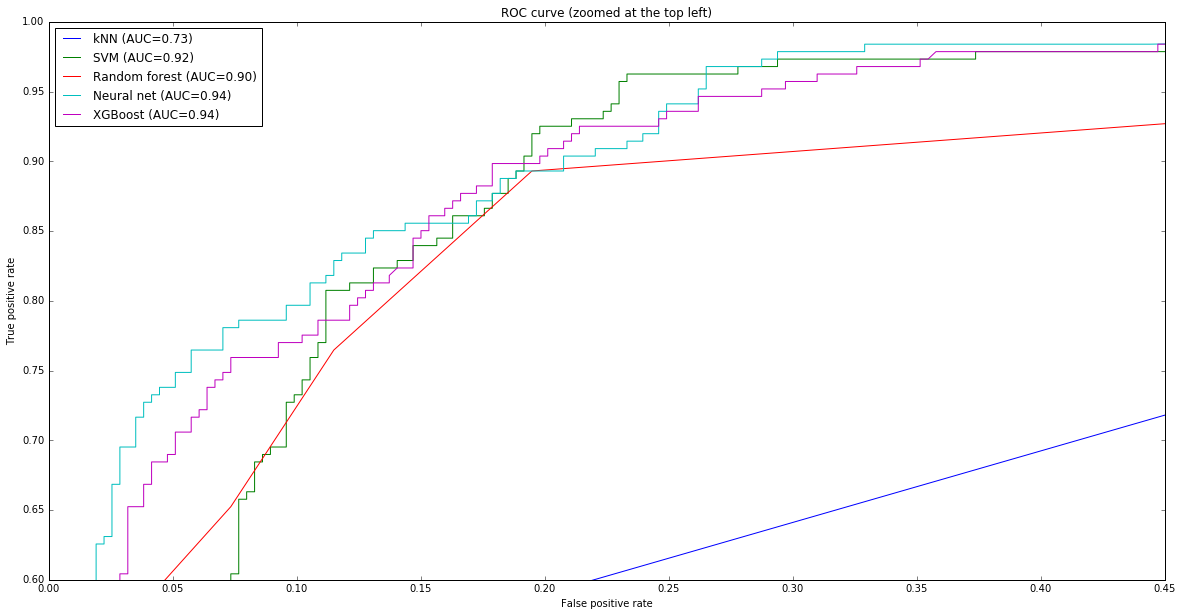

In [557]:
plt.figure(2,figsize=(20,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0, 0.45)
plt.ylim(0.6, 1)
plt.plot(fpr_knn, tpr_knn, label='kNN (AUC=%.2f)' %auc_knn)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC=%.2f)' %auc_svm)
plt.plot(fpr_rf, tpr_rf, label='Random forest (AUC=%.2f)' %auc_rf)
plt.plot(fpr_nn, tpr_nn, label='Neural net (AUC=%.2f)' %auc_nn)
plt.plot(fpr_boost, tpr_boost, label='XGBoost (AUC=%.2f)' %auc_boost)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed at the top left)')
plt.legend(loc='best')
plt.show()

On voit donc clairement que le réseau de neurones offre les meilleurs résultats, la courbe étant globalement au-dessus des autres. Gradient boosting et SVM ont un comportement opposé : les courbes se croisent. 

Selon le but de la classification, le choix optimal peut-être le réseau de neurones ou SVM. Globalement le réseau de neurones a les meilleurs résultats si l'on est indifférent des classes. Revenons sur les matrices de confusion des deux algorithmes:

Confusion matrix, without normalization
[[278  35]
 [ 39 148]]


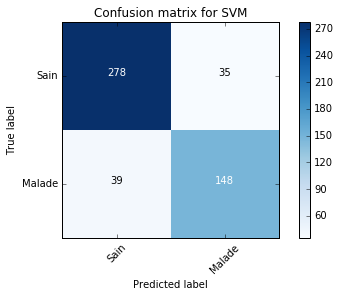

In [558]:
plot_confusion_matrix(cm_svm, classes=['Sain','Malade'], normalize=False, title='Confusion matrix for SVM')

Confusion matrix, without normalization
[[300  13]
 [ 50 137]]


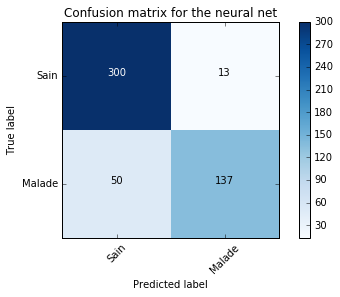

In [559]:
plot_confusion_matrix(cm_nn, classes=['Sain','Malade'], normalize=False, title='Confusion matrix for the neural net')

SVM a tendance à mieux détecter les malades (en tout cas il en rate moins en les classant comme sain). Donc quitte à perdre un peu en déclarant plus d'individus sains comme malades (ce qui peut-être moins grave dans certains cas dans le domaine de la santé), il vaut peut-être mieux utiliser SVM pour passer à coté de moins de malades. 

**Ainsi, comme d'habitude en Data Science, il faut mettre le problème dans son contexte pour décider de l'optimalité d'une solution.**


In [520]:
# ANNEXES

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')